***Welcome*** to the hands-on session for the TUT25 Quantum Week tutorial: *Deep dive into the classical simulation of quantum circuits with QX-simulator*! :)

This notebook contains the first hands-on part, whose goal is to get familiar with the simulation of some cQasm circuits with QX-simulator.

This first hands-on session will last approximately 40 or 45 minutes.

If you have any sort of question or remark, we, the organizers of this tutorial, are here to help you. Please do not hesitate to sollicitate us.

We will regularly show solutions on the screen. You are free to advance in the session at your own pace.

There are a total of 5 main exercises in this notebook:
- a small introductory exercise on **quantum dices** :p
- an exercise on **quantum teleportation**, **mid-circuit measurements** and **classically-controlled quantum gates**
- an exercise that aims at showing that quantum computers can also compute things you would normally do on a classical computer :O
- an exercise on the **Deutsch problem**
- an exercise to write **error-correction codes** in the simulator!

# Install pre-requisites

Please run the below cell before anything else. It installs the qxelarator Python package.

In [ ]:
!pip install qxelarator
import qxelarator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 11.6 MB/s eta 0:00:00


# Introduction to the API of the simulator

We will first learn how to use QX-simulator.

QX-simulator has a very simple API for executing cQasm circuits. It can read a file or a string; in our case we'll only use strings in this notebook.

Here's how it goes: `result = qxelarator.execute_string(s)` will execute the cqasm string `s`, and store result in `result`.

**If the simulation fails for any reason**, `result` is an instance of `qxelarator.SimulationError` which gives an error message when displayed. For instance:


In [ ]:
result = qxelarator.execute_string("""
version 1.0

qubits 2

h q[2]
""")
result

Quantum simulation error: Simulation failed!

`execute_string` take optionally a **number of "shots"** for repeating the simulation and aggregating results. This is passed with the `iterations=` keyword argument. For instance, `qxelarator.execute_string("version 1.0; qubits 2; h q[0]; measure q[0]; cond(b[0]) h q[1]; measure q[1]", iterations=200)` will execute 200 times the circuit and aggregate each output bitstring into a "histogram" (and yes, you can use the semicolon to separate instructions).

In [ ]:
qxelarator.execute_string("version 1.0; qubits 2; h q[0]; measure q[0]; cond(b[0]) h q[1]; measure q[1]", iterations=200)

Shots requested: 200
Shots done: 200
Results: {'00': 87, '01': 60, '11': 53}
State: {'01': (0.9999999999999998+0j)}

The `state` field of the `SimulationResult` object **is always the final state at the end of the last iteration**. **If your circuit ends on a mixed state** (for example if it contains a final measurement on a superposition), this `state` dictionary is non-deterministic.

**If the simulation succeeds**, you get a `qxelarator.SimulationResult` instance. This object has 4 fields:
- `result.shots_requested` is the number of shots that you requested with the `shots=` keyword argument
- `result.shots_done` is the same number, duplicated for compatibility of interfaces with hardware backends (which are not as reliable as the simulator),
- `result.state` is a Python dictionary representing the state: keys are bitstrings like `"0101100"` and values are complex numbers,
- `results.results` are the aggregated counts of end-of-circuit measured bitstrings. It's also a Python dictionary, keys are bitstrings and values are positive integers - 0s are omitted.

**IMPORTANT:** the classical bits are untouched and left in the state `0` if there are no measure. For instance, the `results` dictionary of the following circuit will ALWAYS be all zeros:

In [ ]:
qxelarator.execute_string("""version 1.0; qubits 1; h q[0]""", iterations=1234)

Shots requested: 1234
Shots done: 1234
Results: {'0': 1234}
State: {'0': (0.7071067811865475+0j), '1': (0.7071067811865475+0j)}

Moreover, at the beginning of the execution of a circuit, the state is always in the full-zero ket $\left| 000 \cdots 00 \right>$.

# Dice

## Easy dice

You should know that quantum measurements are non-deterministic. Let's try it out!

**Write an 8-face dice program to test the simulator.**


In [ ]:
# Write your answer here.

In [ ]:
#@title Solution

result = qxelarator.execute_string("""
version 1.0
qubits 3
h q[0:2]
measure_all
""")

print(f"Rolled the dice, got {int(next(iter(result.results)), 2)}")

{'000': (0.3535533905932737+0j),
 '001': (0.3535533905932737+0j),
 '010': (0.3535533905932737+0j),
 '011': (0.3535533905932737+0j),
 '100': (0.3535533905932737+0j),
 '101': (0.3535533905932737+0j),
 '110': (0.3535533905932737+0j),
 '111': (0.3535533905932737+0j)}

Did you find it too easy? Try this next one:

## Advanced dice

[**Advanced**] Write the same example but for a 6-face dice.


Hint: you can use arbitrary-angle rotations `rx`, `ry` or `rz`, for instance `rx q[0], 1.23` for a rotation of angle 1.23 radians around the `x` axis of the Bloch sphere.

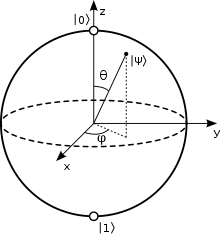


Second hint: the simulator doesn't know about the **controlled-hadamard gate** but you can use [this decomposition](https://quantumcomputing.stackexchange.com/questions/15734/how-to-construct-a-controlled-hadamard-gate-using-single-qubit-gates-and-control).

In [ ]:
# Write your answer here. If you want to use pi import the math library in the beginning


In [ ]:
#@title Solution

import math

result = qxelarator.execute_string(f"""
version 1.0
qubits 3
ry q[2], {2 * math.acos(math.sqrt(2/3))}
h q[0]

x q[2]
ry q[1], {-math.pi / 4}
cz q[2], q[1]
ry q[1], {math.pi / 4}
x q[2]
measure_all
""")
print(f"Rolled the dice, got {int(next(iter(result.results)), 2)}")



{'000': (0.40824829046386296+0j),
 '001': (0.40824829046386296+0j),
 '010': (0.40824829046386296+0j),
 '011': (0.40824829046386296+0j),
 '100': (0.408248290463863+0j),
 '101': (0.408248290463863+0j)}

# Quantum teleportation

**Quantum teleportation** is a method to transfer the state of a quantum bit without breaking the superposition. The following figure shows the circuit that does this. The top of the diagram corresponds to Alice, who wants to teleport the state of her quantum bit to Bob (bottom).

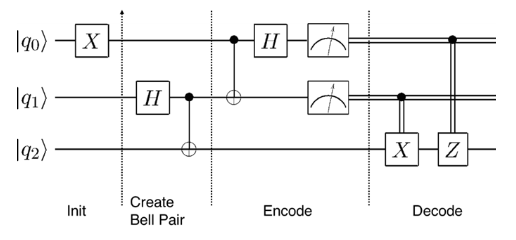

**Note**: initially, the system is in the all-zero state

The steps of the above teleportation are the following:


1.   initialize the qubit that Alice wants to send to state  |1>
2.   create a shared Bell pair
3.   encode the qubit: apply a CNOT on Alice's half of the Bell pair, Hadamard on the data qubit, then measurement of both qubits
4.   send the measurement results to Bob classically
5.   Bob decodes the qubit sent by applying the corresponding operations (corrections) based on the classical bits he received. To this purpose, he uses the received binary values to apply conditional bit flip and/or phase flip on his qubit.

*Understand the quantum state after each step and the corrections that Bob has to apply depending on the binary measurement results.*

*Write the quantum code of the given quantum teleportation circuit.* The circuit should consist of four sub-circuits which corresponds to the teleportation steps `.init`, `.epr`, `.encode` and `.decode`.

*Verify that the state that Bob receives corresponds to the one sent by Alice.* For that, you can freely execute the circuit after changing the `.init` subcircuit and check the `state` field in the simulator's output.

Reminder: in cQasm, `cond(b[i]) x q[j]` applies gate X to qubit #j if the classical bit #i is set.

*What happens to the ancilla qubits after the teleportation is done? Can you teleport qubits again, after teleporting a first qubit? If so, how?*

**[Advanced]** *Write a circuit for teleporting 2 or 3 qubits.* You can use the `map` instruction to give name aliases to your qubits, for instance:
```
map firstTeleportedQubit, q[0]
```

In [ ]:
# Write your answer here.

In [ ]:
#@title Solution

result = qxelarator.execute_string("""
version 1.0

qubits 3

.init
ry q[0], 1.23

.epr
h q[1]
cnot q[1], q[2]

.encode
cnot q[0], q[1]
h q[0]
measure q[0:1]

.decode
cond(b[1]) x q[2]
cond(b[0]) z q[2]
""")

result.state

{'010': (0.8167734469008229+0j), '110': (0.5769585222853968+0j)}

# Classical-quantum adder

Now we will attempt to show that **quantum computers can compute everything a computer can compute** (but we won't use them for that).

We want for that to construct a quantum circuit which implements the **classical addition of two bits**. The quantum circuit can be implemented as a network of **Sum** and **Carry** blocks. These two blocks can be built using CNOT and Toffoli gates. We provide the truth tables of the
CNOT and the Toffoli gates in the table below:

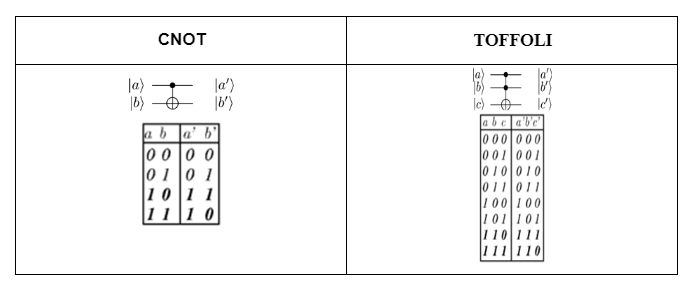

## The **Sum** circuit

Use CNOT gates to implement the **Sum** block which sums two bits `A0` and `B0` (XOR addition) and stores the result in a third bit `S0`. Note: you can use the `map` instruction as detailed below.

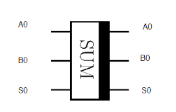


*Write the circuit below.*

The circuit should include three sub-circuits: `.init`, `.sum` and `.carry`, and initialize four qubits. We note that the `.init` circuit initializes `A0` and `B0` inputs, the `.sum` circuit performs the operation and stores the result in `S0`. If both `A0` and `B0` are in the |1⟩ state, a carry qubit `C0` has to represent the result. This should implemented in the `.carry` circuit in the end. Try all input combinations and verify the results.


In [ ]:
# Write your answer here.

In [ ]:
#@title Solution
# The sum is represented in the first 2 qubit states. For example if B0, C01 are in |1> then we should see
# State: {'1011': (1+0j)} which means that the first carry bit fired and the second bit did not fire.

result = qxelarator.execute_string("""# sum
version 1.0

qubits 4
map q[0], A0
map q[1], B0
map q[2], S0
map q[3], C0

.init
 x B0
 x A0

.sum
 cnot A0, S0
 cnot B0, S0

 .carry
 toffoli A0, B0, C0

""")


print(result)



sum
Shots requested: 1
Shots done: 1
Results: {'0000': 1}
State: {'1011': (1+0j)}


# Deutsch Problem

Deutsch’s algorithm creates four functions which maps a set of classical bits to itself. The four mapping functions are the following:

*   Uf1: {0→0; 1→1}
*   Uf2: {0→1; 1→0}
*   Uf3: {0→0; 1→0}
*   Uf4: {0→1; 1→1}

You can notice that these four functions cover every possible mapping between {0,1}⟼{0,1}. We define a constant function as f(0)=f(1) and we define a balanced function as f(0)≠f(1). Therefore Uf1 and Uf2 are balanced while Uf3 and Uf4 are constant.

Without knowing which of these functions are used, Deutsch’s algorithm can detect whether the used function Uf is constant or balanced. While a classical algorithm needs to evaluate f(0)
and then f(1) to decide whether they are equal or different, Deutsch’s quantum algorithm can evaluate them simultaneously using the quantum superposition of the basis states.

We want to write and simulate the quantum circuit implementing Deutsch’s algorithm.

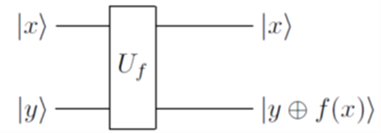

## Exercise
Write the four circuits implementing Deutsch’s algorithm and use each of the implemented four Uf functions.

Each of the four circuits should contain four sub-circuits:
1.	The first sub-circuit is named `.init` and initializes the two qubits as follows: qx to |0⟩ and qy to |1⟩.
2.	The second sub-circuit puts the qubits into a superposition and should be named `.superposition`.
3.	The third sub-circuit implements the Uf function.
4.	The last sub-circuit is called `.result` and applies an H gate on the top qubit and measures it.

Simulate the execution of the four circuits and verify that the outcome of the qubit measurement is 1 when a balanced function is used and 0 when a constant one is used.

In [ ]:
# Write your answer here.

###Solution

In [ ]:
result = qxelarator.execute_string("""## deutsch_uf1
version 1.0
qubits 2

map q[0], qx;
map q[1], qy;

.init
   x qy

.superposition
   h qx
   h qy

.uf1
   cnot qx, qy

.result
   h qx
   measure qx
""")
print("deutsch_uf1")
print(result)

result = qxelarator.execute_string("""### deutsch_uf2

version 1.0

qubits 2
map q[0], qx
map q[1], qy

.init
 x qy

.superposition
 h qx
 h qy

.uf2
 x qx
 cnot qx, qy

.result
 h qx
 measure qx

""")
print("deutsch_uf2")
print(result)


result = qxelarator.execute_string("""## deutsch_uf3
version 1.0

qubits 2
map q[0], qx
map q[1], qy

.init
 x qy

.superposition
 h qx
 h qy

.uf3

.result
 h qx
 measure qx

""")
print("deutsch_uf3")
print(result)

result = qxelarator.execute_string("""# deutsch_uf4
version 1.0

qubits 2
map q[0], qx
map q[1], qy

.init
 x qy

.superposition
 h qx
 h qy

.uf4
 x qy

.result
 h qx
 measure qx

""")
print("deutsch_uf4")
print(result)

deutsch_uf1
Shots requested: 1
Shots done: 1
Results: {'01': 1}
State: {'01': (0.7071067811865475+0j), '11': (-0.7071067811865475+0j)}
deutsch_uf2
Shots requested: 1
Shots done: 1
Results: {'01': 1}
State: {'01': (0.7071067811865475+0j), '11': (-0.7071067811865475+0j)}
deutsch_uf3
Shots requested: 1
Shots done: 1
Results: {'00': 1}
State: {'00': (0.7071067811865474+0j), '10': (-0.7071067811865474+0j)}
deutsch_uf4
Shots requested: 1
Shots done: 1
Results: {'00': 1}
State: {'00': (-0.7071067811865474+0j), '10': (0.7071067811865474+0j)}


# Shor error correction code

In general terms, in quantum error correction you first encode a logical qubit into multiple physical qubits. Next, you measure "error syndromes" using extra "ancilla" qubits to detect errors without disturbing the quantum state. Based on these measurements, you apply corrective operations to reverse the errors, such as using a Pauli-X gate to fix a detected bit-flip. A rough cicruit representation of an error correction code is the following. :

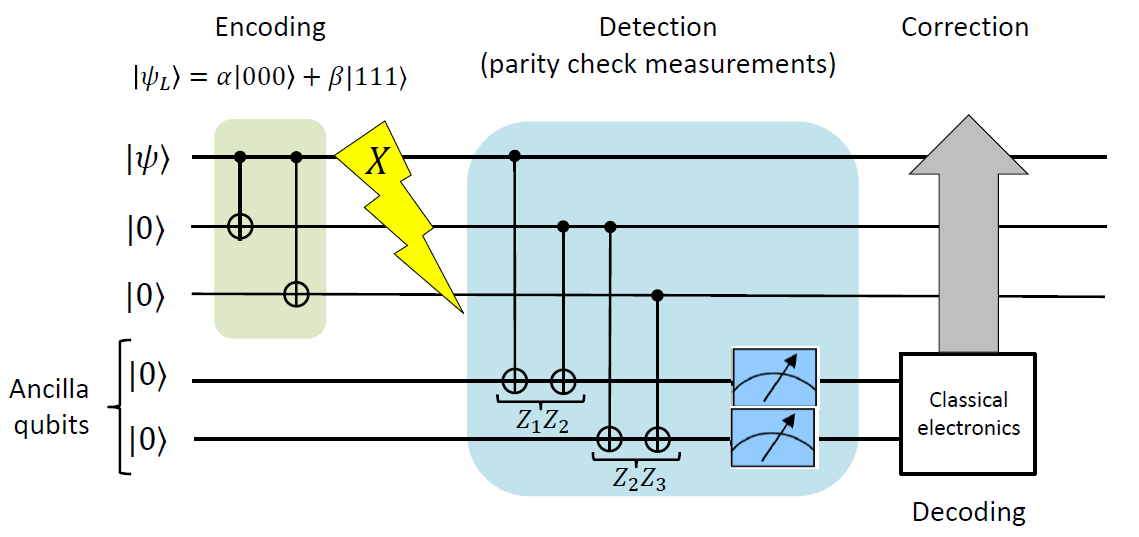

Shor code is a 9-qubit error correction code which corrects both bit-flip and phase-flip errors simultaneously. Thus, the code combines the 3-qubit bit-flip code and the 3-qubit phase-flip code.We need 8 ancilla qubits to detect possible errors. However, we can detect and correct errors without using ancilla qubits as shown in the following figure:

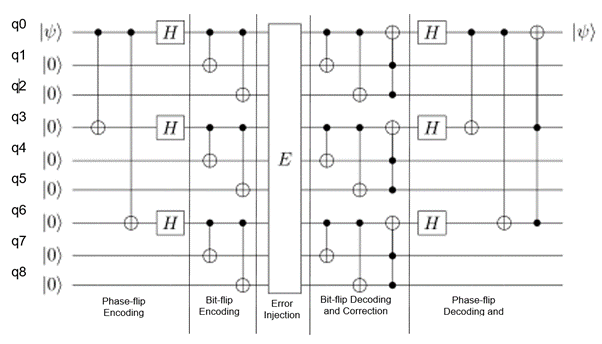

Before executing the circuit, we want to initialize the state of qubit 0 (the qubit we want to encode) using the following sub-circuit:

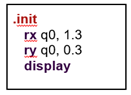

1) Run the circuit and check the final state of the first qubit (after correction and decoding).

2) Now, modify the inject_error section to inject one bit flip on qubit q0.  What do you observe? Repeat the same for a bit flip on qubit 3 (q3).

3) Finally, modify the inject_error section to inject the following errors:

*   Bit-flip on qubit q0  
*   Phase-flip on qubit q0
*   Phase-flip on qubit q0

What do you observe and why?


In [ ]:
# take-home message: it can correct 1 or 2 erros but not 3 The circuit fails to correct the 3 errors
# (the decoded state is different from the initially encoded state)
# because this error correction code can correct only single bit flip error, phase flip error or both.

result = qxelarator.execute_string("""
version 1.0
qubits 9

.init
rx q[0], 1.3
ry q[0], 0.3

.phase_flip_encode
cnot q[0], q[3]
cnot q[0], q[6]
 h q[0] ; h q[3] ; h q[6]

.bit_flip_encode
 cnot q[0], q[1] ; cnot q[3], q[4] ; cnot q[6], q[7]
 cnot q[0], q[2] ; cnot q[3], q[5] ; cnot q[6], q[8]

.inject_error
 # x q[3]
 # x q[0]
 # z q[0]
 # x q[1]

.bit_flip_decode_and_correct
 cnot q[0], q[1] ; cnot q[3], q[4] ; cnot q[6], q[7]
 cnot q[0], q[2] ; cnot q[3], q[5] ; cnot q[6], q[8]
 toffoli q[2], q[1], q[0] ; toffoli q[5], q[4], q[3] ; toffoli q[8], q[7], q[6]

.phase_flip_decode_and_correct
 h q[0] ; h q[3] ; h q[6]
cnot q[0], q[3]
cnot q[0], q[6]
toffoli q[6], q[3], q[0]
# measure q[0];
  """)
result

Shots requested: 1
Shots done: 1
Results: {'000000000': 1}
State: {'000000000': (0.7871446356187686+0.09043792627160356j), '000000001': (0.11896527614765982-0.5983908147518625j)}